Useful resources used: https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial9/AE_CIFAR10.html

https://www.kaggle.com/code/rvislaywade/visualizing-mnist-using-a-variational-autoencoder


In [20]:
import jax
import jax.numpy as jnp
import numpy as np
from flax import linen as nn
from flax.training import train_state
import optax
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [2]:
class Autoencoder(nn.Module):
    latent_dim: int

    @nn.compact
    def __call__(self, x, return_latent=False):
        x = x.reshape((x.shape[0], -1))


        z = nn.Dense(128)(x)
        z = nn.relu(z)
        z = nn.Dense(64)(z)
        z = nn.relu(z)
        z = nn.Dense(64)(z)
        z = nn.relu(z)


        latent = nn.Dense(self.latent_dim)(z)


        if return_latent:
            return latent

        x_recon = nn.Dense(64)(latent)
        x_recon = nn.relu(x_recon)
        x_recon = nn.Dense(64)(x_recon)
        x_recon = nn.relu(x_recon)
        x_recon = nn.Dense(128)(x_recon)
        x_recon = nn.relu(x_recon)
        x_recon = nn.Dense(28 * 28)(x_recon)
        x_recon = x_recon.reshape((-1, 28, 28))

        return x_recon



In [3]:
class ConvAutoencoder(nn.Module):
    latent_dim: int

    @nn.compact
    def __call__(self, x, return_latent=False):
        x = x.reshape((-1, 28, 28, 1))        #(batch_size, height, width, channels)

        x = nn.Conv(features=32, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(x)
        x = nn.relu(x)
        x = nn.Conv(features=64, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(x)
        x = nn.relu(x)
        x = x.reshape((x.shape[0], -1))

        latent = nn.Dense(self.latent_dim)(x)

        if return_latent:
            return latent

        x_recon = nn.Dense(7 * 7 * 64)(latent)
        x_recon = x_recon.reshape((-1, 7, 7, 64))
        x_recon = nn.ConvTranspose(features=32, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(x_recon)
        x_recon = nn.relu(x_recon)
        x_recon = nn.ConvTranspose(features=1, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(x_recon)
        x_recon = x_recon.reshape((-1, 28, 28))

        return x_recon


In [4]:

class VAE(nn.Module):
    latent_dim: int

    def setup(self):
        self.encoder_dense1 = nn.Dense(128)
        self.encoder_dense2 = nn.Dense(64)
        self.encoder_dense3 = nn.Dense(64)
        self.mu_dense = nn.Dense(self.latent_dim)
        self.logvar_dense = nn.Dense(self.latent_dim)

        self.decoder_dense1 = nn.Dense(64)
        self.decoder_dense2 = nn.Dense(64)
        self.decoder_dense3 = nn.Dense(128)
        self.decoder_output = nn.Dense(28 * 28)

    @nn.compact
    def __call__(self, x, rng=None, return_latent=False):
        x = x.reshape((x.shape[0], -1))  # Flatten

        h = self.encoder_dense1(x)
        h = nn.relu(h)
        h = self.encoder_dense2(h)
        h = nn.relu(h)
        h = self.encoder_dense3(h)
        h = nn.relu(h)

        mu = self.mu_dense(h)
        logvar = self.logvar_dense(h)


        std = jnp.exp(0.5 * logvar)
        if rng is None:
            rng = self.make_rng('latent')  #dflt
        eps = jax.random.normal(rng, std.shape)
        z = mu + eps * std


        if return_latent:
            return z, mu, logvar

        x_recon = self.decode(z)
        return x_recon, mu, logvar

    def decode(self, z):
        h = self.decoder_dense1(z)
        h = nn.relu(h)
        h = self.decoder_dense2(h)
        h = nn.relu(h)
        h = self.decoder_dense3(h)
        h = nn.relu(h)
        x_recon = self.decoder_output(h)
        x_recon = x_recon.reshape((-1, 28, 28))
        return x_recon



In [5]:
class ConvVAE(nn.Module):
    latent_dim: int

    @nn.compact
    def __call__(self, x, return_latent=False):
        x = x.reshape((-1, 28, 28, 1))        #(batch_size, height, width, channels)

        x = nn.Conv(features=32, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(x)
        x = nn.relu(x)
        x = nn.Conv(features=64, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(x)
        x = nn.relu(x)
        x = x.reshape((x.shape[0], -1))

        mu = nn.Dense(self.latent_dim)(x)
        logvar = nn.Dense(self.latent_dim)(x)

        # Reparameterization
        std = jnp.exp(0.5 * logvar)
        rng = self.make_rng('latent')
        eps = jax.random.normal(rng, std.shape)
        z = mu + eps * std
        if return_latent:
            return z, mu, logvar


        x_recon = nn.Dense(7 * 7 * 64)(z)
        x_recon = x_recon.reshape((-1, 7, 7, 64))
        x_recon = nn.ConvTranspose(features=32, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(x_recon)
        x_recon = nn.relu(x_recon)
        x_recon = nn.ConvTranspose(features=1, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(x_recon)
        x_recon = x_recon.reshape((-1, 28, 28))

        return x_recon, mu, logvar


In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.12MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 65.6kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.77MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
"""def mse_loss(y_true, y_pred):
    return jnp.mean((y_true - y_pred) ** 2)

def VAE_loss(y_true, y_pred, mu, logvar, beta=0.01):
    recon_loss = jnp.mean((y_true - y_pred) ** 2)
    # KL divergence loss - needs beta scaling
    kl_loss = -0.5 * jnp.mean(1 + logvar - mu ** 2 - jnp.exp(logvar))
    return recon_loss + beta * kl_loss"""


'def mse_loss(y_true, y_pred):\n    return jnp.mean((y_true - y_pred) ** 2)\n\ndef VAE_loss(y_true, y_pred, mu, logvar, beta=0.01):\n    recon_loss = jnp.mean((y_true - y_pred) ** 2)\n    # KL divergence loss - needs beta scaling\n    kl_loss = -0.5 * jnp.mean(1 + logvar - mu ** 2 - jnp.exp(logvar))\n    return recon_loss + beta * kl_loss'

In [8]:
def mse_loss(y_true, y_pred):
    return jnp.sum((y_true - y_pred) ** 2)

def VAE_loss(y_true, y_pred, mu, logvar, beta=1):
    # Summed  losses now
    recon_loss = jnp.sum((y_true - y_pred) ** 2)

    kl_loss = -0.5 * jnp.sum(1 + logvar - mu ** 2 - jnp.exp(logvar))

    return recon_loss + kl_loss * beta # setting beta to 1


In [9]:
@jax.jit
def train_step(state, batch):
    def loss_fn(params):
        recon_x = state.apply_fn({'params': params}, batch)
        loss = mse_loss(batch, recon_x)
        return loss

    grads = jax.grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state

@jax.jit
def train_step_VAE(state, batch, rng):
    def loss_fn(params):
        rngs = {'params': rng, 'latent': rng}
        x_recon, mu, logvar = state.apply_fn({'params': params}, batch, rngs=rngs)
        loss = VAE_loss(batch, x_recon, mu, logvar)
        return loss

    grads = jax.grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state



In [10]:
rng = jax.random.PRNGKey(0)

sample_input = jnp.ones([1, 28, 28])

latent_dimensions = 4
model = Autoencoder(latent_dim=latent_dimensions)
model_conv = ConvAutoencoder(latent_dim=latent_dimensions)
model_VAE = VAE(latent_dim=latent_dimensions)
model_VAE_conv = ConvVAE(latent_dim=latent_dimensions)

params = model.init(rng, sample_input)['params']
params_conv = model_conv.init(rng, sample_input)['params']

rng, rng_init = jax.random.split(rng)
rngs_init_vae = {'params': rng_init, 'latent': rng_init}

params_vae = model_VAE.init(rngs_init_vae, sample_input)['params']
params_vae_conv = model_VAE_conv.init(rngs_init_vae, sample_input)['params']


learning_rate = 1e-3
optimizer = optax.adam(learning_rate)


state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=optimizer
)

state_conv = train_state.TrainState.create(
    apply_fn=model_conv.apply,
    params=params_conv,
    tx=optimizer
)

state_vae = train_state.TrainState.create(
    apply_fn=model_VAE.apply,
    params=params_vae,
    tx=optimizer
)

state_vae_conv = train_state.TrainState.create(
    apply_fn=model_VAE_conv.apply,
    params=params_vae_conv,
    tx=optimizer
)


In [11]:
num_epochs = 5

for epoch in range(num_epochs):
    for batch_idx, (data, _) in enumerate(train_loader):

        data = data.view(-1, 28, 28).numpy()
        data = jnp.array(data)

        state = train_step(state, data)
    print(f'Epoch dense AE {epoch + 1} completed.')

Epoch dense AE 1 completed.
Epoch dense AE 2 completed.
Epoch dense AE 3 completed.
Epoch dense AE 4 completed.
Epoch dense AE 5 completed.


In [12]:

for epoch in range(num_epochs):
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, 28, 28).numpy()
        data = jnp.array(data)
        state_conv = train_step(state_conv, data)
    print(f'Epoch conv AE {epoch + 1} completed.')


Epoch conv AE 1 completed.
Epoch conv AE 2 completed.
Epoch conv AE 3 completed.
Epoch conv AE 4 completed.
Epoch conv AE 5 completed.


In [13]:

for epoch in range(num_epochs):
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, 28, 28).numpy()
        data = jnp.array(data)
        rng, rng_step = jax.random.split(rng)
        state_vae = train_step_VAE(state_vae, data, rng_step)
    print(f'Epoch VAE {epoch + 1} completed.')

Epoch VAE 1 completed.
Epoch VAE 2 completed.
Epoch VAE 3 completed.
Epoch VAE 4 completed.
Epoch VAE 5 completed.


In [14]:

for epoch in range(num_epochs):
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, 28, 28).numpy()
        data = jnp.array(data)
        rng, rng_step = jax.random.split(rng)
        state_vae_conv = train_step_VAE(state_vae_conv, data, rng_step)
    print(f'Epoch conv VAE {epoch + 1} completed.')

Epoch conv VAE 1 completed.
Epoch conv VAE 2 completed.
Epoch conv VAE 3 completed.
Epoch conv VAE 4 completed.
Epoch conv VAE 5 completed.


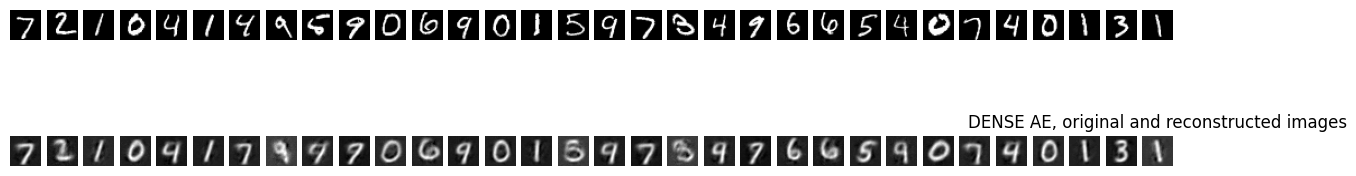

Losses for each image: [Array(55.434258, dtype=float32), Array(155.86533, dtype=float32), Array(24.003502, dtype=float32), Array(72.63365, dtype=float32), Array(74.701004, dtype=float32), Array(21.819256, dtype=float32), Array(167.98451, dtype=float32), Array(132.55396, dtype=float32), Array(291.61792, dtype=float32), Array(83.774055, dtype=float32), Array(94.488266, dtype=float32), Array(159.72781, dtype=float32), Array(51.80977, dtype=float32), Array(72.83583, dtype=float32), Array(32.920288, dtype=float32), Array(117.1917, dtype=float32), Array(81.79051, dtype=float32), Array(93.83004, dtype=float32), Array(123.594635, dtype=float32), Array(62.52863, dtype=float32), Array(105.515884, dtype=float32), Array(80.39358, dtype=float32), Array(134.14658, dtype=float32), Array(100.79344, dtype=float32), Array(62.33397, dtype=float32), Array(117.100784, dtype=float32), Array(69.13922, dtype=float32), Array(77.99134, dtype=float32), Array(74.168816, dtype=float32), Array(35.36449, dtype=float

In [24]:
test_iter = iter(test_loader)
test_data, _ = next(test_iter)
test_data = test_data.view(-1, 28, 28).numpy()
test_data = jnp.array(test_data)

reconstructed = model.apply({'params': state.params}, test_data)

loss = []
fig, axes = plt.subplots(2, 32, figsize=(15, 3))

for i in range(32):
    axes[0, i].imshow(test_data[i], cmap='gray')
    axes[0, i].axis('off')

    axes[1, i].imshow(reconstructed[i], cmap='gray')
    axes[1, i].axis('off')
    loss.append(mse_loss(test_data[i], reconstructed[i]))
plt.title("DENSE AE, original and reconstructed images")
plt.show()
print("Losses for each image:", loss)
print("Average loss:", np.mean(loss))



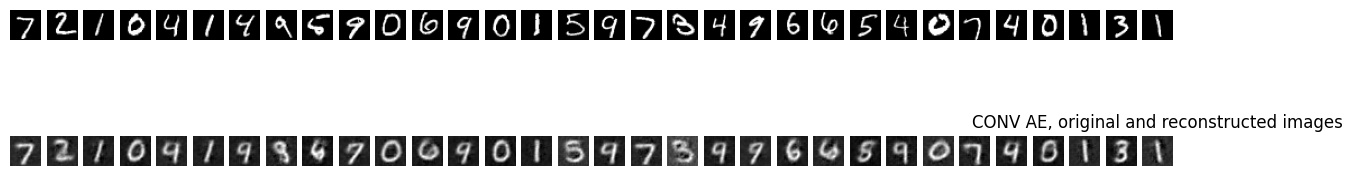

Losses for each image: [Array(53.41297, dtype=float32), Array(183.47537, dtype=float32), Array(25.880108, dtype=float32), Array(105.843346, dtype=float32), Array(83.01412, dtype=float32), Array(20.880785, dtype=float32), Array(162.28174, dtype=float32), Array(140.17343, dtype=float32), Array(253.47266, dtype=float32), Array(88.79794, dtype=float32), Array(87.572266, dtype=float32), Array(166.79755, dtype=float32), Array(64.351875, dtype=float32), Array(95.25719, dtype=float32), Array(34.107327, dtype=float32), Array(128.63252, dtype=float32), Array(95.86064, dtype=float32), Array(91.2296, dtype=float32), Array(190.26866, dtype=float32), Array(65.19775, dtype=float32), Array(83.13508, dtype=float32), Array(87.93681, dtype=float32), Array(141.2197, dtype=float32), Array(107.6025, dtype=float32), Array(67.90902, dtype=float32), Array(125.27904, dtype=float32), Array(66.026146, dtype=float32), Array(77.068596, dtype=float32), Array(102.082016, dtype=float32), Array(48.11061, dtype=float32)

In [25]:
test_iter = iter(test_loader)
test_data, _ = next(test_iter)
test_data = test_data.view(-1, 28, 28).numpy()
test_data = jnp.array(test_data)

reconstructed_conv = model_conv.apply({'params': state_conv.params}, test_data)
fig, axes = plt.subplots(2, 32, figsize=(15, 3))
loss=[]
for i in range(32):
    axes[0, i].imshow(test_data[i], cmap='gray')
    axes[0, i].axis('off')

    axes[1, i].imshow(reconstructed_conv[i], cmap='gray')
    axes[1, i].axis('off')
    loss.append(mse_loss(test_data[i], reconstructed_conv[i]))
plt.title("CONV AE, original and reconstructed images")
plt.show()
print("Losses for each image:", loss)
print("Average loss:", np.mean(loss))

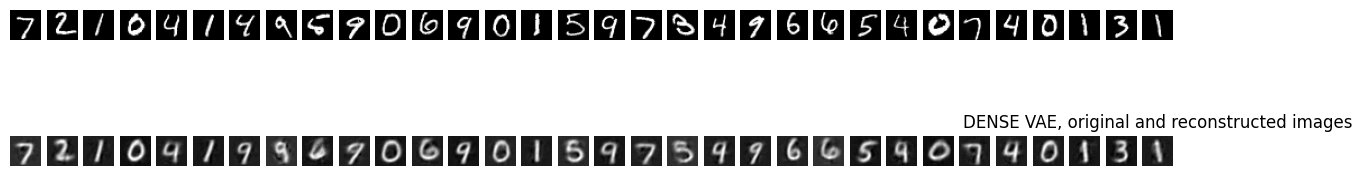

Losses for each image: [Array(54.677223, dtype=float32), Array(190.02371, dtype=float32), Array(27.167864, dtype=float32), Array(76.66469, dtype=float32), Array(70.8631, dtype=float32), Array(21.282122, dtype=float32), Array(155.83255, dtype=float32), Array(122.9086, dtype=float32), Array(287.15872, dtype=float32), Array(69.153206, dtype=float32), Array(88.012665, dtype=float32), Array(159.21729, dtype=float32), Array(65.88689, dtype=float32), Array(73.26622, dtype=float32), Array(29.156408, dtype=float32), Array(130.68463, dtype=float32), Array(76.01002, dtype=float32), Array(69.650635, dtype=float32), Array(190.77411, dtype=float32), Array(63.035553, dtype=float32), Array(65.82867, dtype=float32), Array(77.370445, dtype=float32), Array(146.20935, dtype=float32), Array(97.775276, dtype=float32), Array(69.16909, dtype=float32), Array(130.05333, dtype=float32), Array(66.013985, dtype=float32), Array(86.09241, dtype=float32), Array(92.42468, dtype=float32), Array(51.588345, dtype=float32

In [26]:
test_iter = iter(test_loader)
test_data, _ = next(test_iter)
test_data = test_data.view(-1, 28, 28).numpy()
test_data = jnp.array(test_data)

rng = jax.random.PRNGKey(42)

rng, rng_apply = jax.random.split(rng)
reconstructed_VAE, mu, logvar = model_VAE.apply(
    {'params': state_vae.params},
    test_data,
    rngs={'params': rng_apply, 'latent': rng_apply}
)

fig, axes = plt.subplots(2, 32, figsize=(15, 3))
loss = []

for i in range(32):
    axes[0, i].imshow(test_data[i], cmap='gray')
    axes[0, i].axis('off')

    axes[1, i].imshow(reconstructed_VAE[i], cmap='gray')
    axes[1, i].axis('off')

    loss.append(mse_loss(test_data[i], reconstructed_VAE[i]))
plt.title("DENSE VAE, original and reconstructed images")
plt.show()
print("Losses for each image:", loss)
print("Average loss:", np.mean(loss))

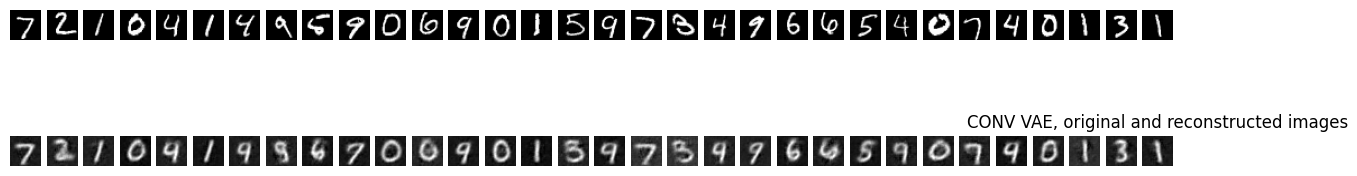

Losses for each image: [Array(60.532806, dtype=float32), Array(179.60304, dtype=float32), Array(26.025028, dtype=float32), Array(111.59569, dtype=float32), Array(94.54079, dtype=float32), Array(23.165108, dtype=float32), Array(173.01001, dtype=float32), Array(138.26453, dtype=float32), Array(260.9666, dtype=float32), Array(88.38034, dtype=float32), Array(98.42389, dtype=float32), Array(166.3057, dtype=float32), Array(62.097878, dtype=float32), Array(101.4816, dtype=float32), Array(35.109966, dtype=float32), Array(126.19774, dtype=float32), Array(89.05154, dtype=float32), Array(94.73536, dtype=float32), Array(167.70926, dtype=float32), Array(68.00224, dtype=float32), Array(81.96525, dtype=float32), Array(91.29095, dtype=float32), Array(130.26996, dtype=float32), Array(106.49136, dtype=float32), Array(79.14181, dtype=float32), Array(135.63853, dtype=float32), Array(67.477585, dtype=float32), Array(86.29918, dtype=float32), Array(103.38158, dtype=float32), Array(58.233696, dtype=float32),

In [27]:

test_iter = iter(test_loader)
test_data, _ = next(test_iter)
test_data = test_data.view(-1, 28, 28).numpy()
test_data = jnp.array(test_data)


rng = jax.random.PRNGKey(43)


rng, rng_apply = jax.random.split(rng)
reconstructed_VAE_conv, mu, logvar = model_VAE_conv.apply(
    {'params': state_vae_conv.params},
    test_data,
    rngs={'params': rng_apply, 'latent': rng_apply}
)

fig, axes = plt.subplots(2, 32, figsize=(15, 3))
loss = []

for i in range(32):
    axes[0, i].imshow(test_data[i], cmap='gray')
    axes[0, i].axis('off')

    axes[1, i].imshow(reconstructed_VAE_conv[i], cmap='gray')
    axes[1, i].axis('off')

    loss.append(mse_loss(test_data[i], reconstructed_VAE_conv[i]))
plt.title("CONV VAE, original and reconstructed images")
plt.show()
print("Losses for each image:", loss)
print("Average loss:", np.mean(loss))

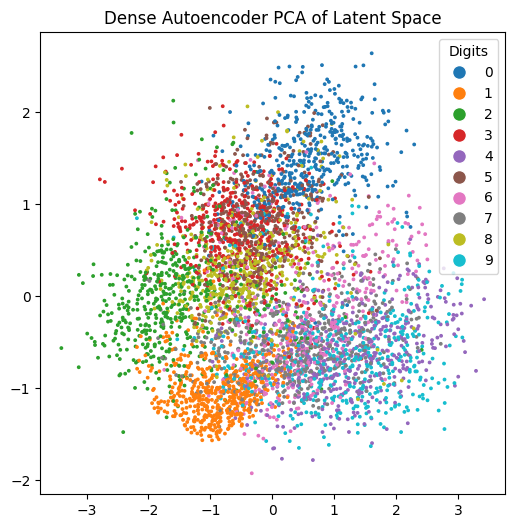

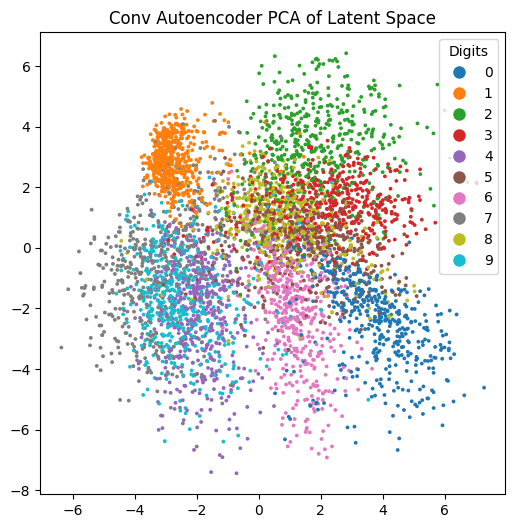

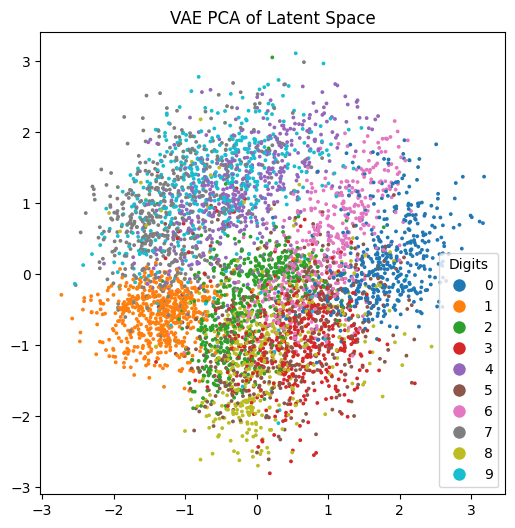

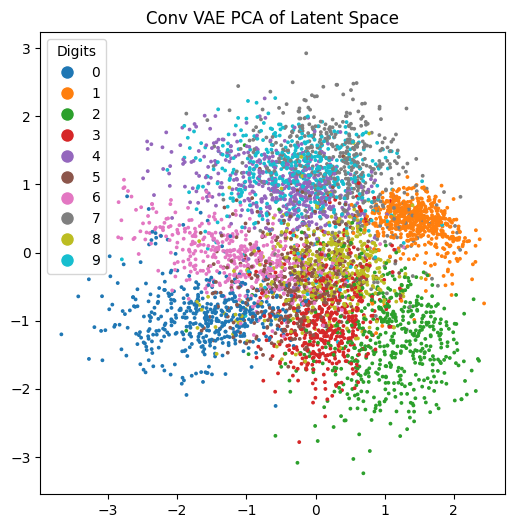

In [31]:
from sklearn.decomposition import PCA


def plot_latent_space(test_loader, model, state, num_points=1000, is_vae=False, title='PCA of Latent Space'):
    latent_spaces = []
    all_labels = []


    points_collected = 0
    for data, labels in test_loader:
        data = data.view(-1, 28, 28).numpy()
        data = jnp.array(data)

        if is_vae:
            rng = jax.random.PRNGKey(0)
            latent_batch, _, _ = model.apply({'params': state.params}, data, return_latent=True, rngs={'latent': rng})
        else:
            latent_batch = model.apply({'params': state.params}, data, return_latent=True)


        latent_spaces.append(latent_batch)
        all_labels.append(labels.numpy())

        points_collected += len(data)
        if points_collected >= num_points:
            break
    latent_spaces = jnp.concatenate(latent_spaces, axis=0)[:num_points]
    all_labels = np.concatenate(all_labels, axis=0)[:num_points]

    fig, axes =  plt.subplots(1, 1, figsize=(6, 6))


    latent_2d_pca = PCA(n_components=2).fit_transform(latent_spaces)
    ax = axes
    scatter_pca = ax.scatter(latent_2d_pca[:, 0], latent_2d_pca[:, 1], c=all_labels, cmap='tab10', s=3)
    ax.set_title(title)

    legend_labels = np.unique(all_labels)
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter_pca.cmap(scatter_pca.norm(i)), markersize=10) for i in legend_labels]
    ax.legend(handles, legend_labels, title="Digits")

    plt.show()

plot_latent_space(test_loader, model, state, num_points=5000, is_vae=False, title='Dense Autoencoder PCA of Latent Space')
plot_latent_space(test_loader, model_conv, state_conv, num_points=5000, is_vae=False, title ='Conv Autoencoder PCA of Latent Space')
plot_latent_space(test_loader, model_VAE, state_vae, num_points=5000, is_vae=True, title='VAE PCA of Latent Space')
plot_latent_space(test_loader, model_VAE_conv, state_vae_conv, num_points=5000, is_vae=True, title='Conv VAE PCA of Latent Space')


In [32]:
import plotly.express as px
import plotly.graph_objects as go
#plotly for 3d plotting

def plot_latent_space_3d_interactive(test_loader, model, state, num_points=1000, point_size=5, is_vae=False, title='3D PCA of latent space'):
    latent_spaces = []
    all_labels = []

    points_collected = 0
    for data, labels in test_loader:
        data = data.view(-1, 28, 28).numpy()
        data = jnp.array(data)

        if is_vae:
            rng = jax.random.PRNGKey(0)
            latent_batch, _, _ = model.apply({'params': state.params}, data, return_latent=True, rngs={'latent': rng})
        else:
            latent_batch = model.apply({'params': state.params}, data, return_latent=True)
        latent_batch = latent_batch.reshape((latent_batch.shape[0], -1))
        latent_spaces.append(latent_batch)
        all_labels.append(labels.numpy())
        points_collected += len(data)
        if points_collected >= num_points:
            break
    latent_spaces = jnp.concatenate(latent_spaces, axis=0)[:num_points]
    all_labels = np.concatenate(all_labels, axis=0)[:num_points]
    all_labels = [str(label) for label in all_labels]

    latent_3d_pca = PCA(n_components=3).fit_transform(latent_spaces)
    fig = px.scatter_3d(x=latent_3d_pca[:, 0], y=latent_3d_pca[:, 1], z=latent_3d_pca[:, 2],
                        color=all_labels, labels={'color': 'Digits'},
                        color_discrete_sequence=px.colors.qualitative.T10)
    fig.update_traces(marker=dict(size=point_size))
    fig.update_layout(title=title, scene=dict(
        xaxis_title="PC1", yaxis_title="PC2", zaxis_title="PC3"
    ))
    fig.show()



plot_latent_space_3d_interactive(test_loader, model, state, num_points=10000, point_size=2, is_vae=False, title='3D PCA of Latent Space of Dense AE')
plot_latent_space_3d_interactive(test_loader, model_conv, state_conv, num_points=10000, point_size=2, is_vae=False, title='3D PCA of Latent Space of Conv AE')

plot_latent_space_3d_interactive(test_loader, model_VAE, state_vae, num_points=10000, point_size=2, is_vae=True, title='3D PCA of Latent Space of VAE')
plot_latent_space_3d_interactive(test_loader, model_VAE_conv, state_vae_conv, num_points=10000, point_size=2, is_vae=True, title='3D PCA of Latent Space of VAE')


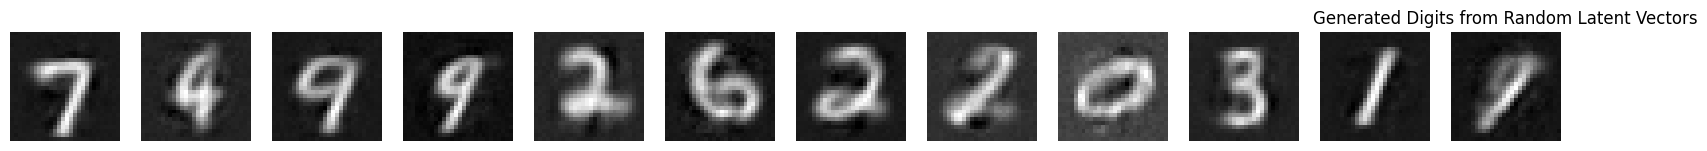

In [40]:
def sample_and_generate_digit(model, state, latent_dim, num_samples=1, prng=0):
    rng = jax.random.PRNGKey(prng)
    z = jax.random.normal(rng, (num_samples, latent_dim))

    generated_images = model.apply({'params': state.params}, z, method=model.decode)

    fig, axes = plt.subplots(1, num_samples, figsize=(20, 2))
    if num_samples == 1:
        axes = [axes]

    for i, ax in enumerate(axes):
        ax.imshow(generated_images[i], cmap='gray')
        ax.axis('off')

    plt.title('Generated Digits from Random Latent Vectors')
    plt.show()

sample_and_generate_digit(model_VAE, state_vae, latent_dimensions, num_samples=12)


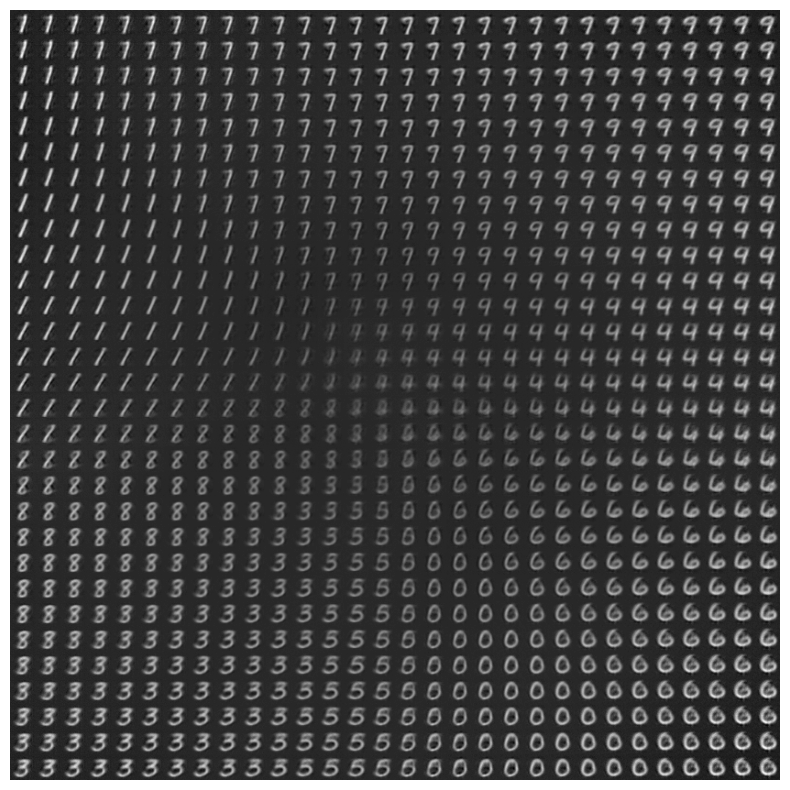

In [42]:
def visualize_latent_space_pca(model, state, data_loader, latent_dim, grid_size=20,  prng=1):

    latent_vectors = []
    for batch, _ in data_loader:
        batch = batch.view(-1, 28, 28).numpy()
        batch = jnp.array(batch)
        z, _, _ = model.apply({'params': state.params}, batch, return_latent=True, rngs={'latent': jax.random.PRNGKey(prng)})
        latent_vectors.append(z)


    latent_vectors = jnp.concatenate(latent_vectors, axis=0)

    pca = PCA(n_components=2)
    latent_pca = pca.fit_transform(latent_vectors)

    grid_x = np.linspace(latent_pca[:, 0].min(), latent_pca[:, 0].max(), grid_size)
    grid_y = np.linspace(latent_pca[:, 1].min(), latent_pca[:, 1].max(), grid_size)

    prng = jax.random.PRNGKey(prng)

    figure = np.zeros((28 * grid_size, 28 * grid_size))

    for i, xi in enumerate(grid_x):
        for j, yi in enumerate(grid_y):
            z_pca_sample = pca.inverse_transform([[xi, yi]])
            z_sample = jnp.array(z_pca_sample)

            prng, subkey = jax.random.split(prng)
            decoded_image = model.apply({'params': state.params}, z_sample, rngs={'latent': subkey}, method=model.decode)

            digit = np.array(decoded_image[0]).reshape(28, 28)
            figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='gray')
    plt.axis("off")
    plt.show()

visualize_latent_space_pca(model_VAE, state_vae, test_loader, latent_dim=2, grid_size=30, prng=1)
